<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/CAVIA/context_aware_token_CNN_CAVIA_afml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**cavia + ridge regression**

**CAVIA part:**

Learns a small context vector that adapts per task. Inner-loop updates this context on the support set. Outer-loop updates the model parameters (CNN + projection layers).

**Ridge regression part:**

Once the support embeddings are computed, it solves a closed-form linear classifier (ridge regression) to map embeddings → class logits. This avoids heavy gradient steps on the classifier itself, which is very data-efficient for few-shot tasks.

Using device: cpu
Filtered dataset: 6368 samples
Unique groups: 107
Number of classes: 107
Valid sequences for vocabulary: 6368/6368
Vocab size: 1026
Epoch 10/180, Loss=1.6387, Train Acc=1.0000, Test Acc=0.3050
Epoch 20/180, Loss=1.6223, Train Acc=1.0000, Test Acc=0.3337
Epoch 30/180, Loss=1.6094, Train Acc=1.0000, Test Acc=0.3677
Epoch 40/180, Loss=1.4629, Train Acc=1.0000, Test Acc=0.5067
Epoch 50/180, Loss=1.4819, Train Acc=1.0000, Test Acc=0.5256
Epoch 60/180, Loss=1.3588, Train Acc=1.0000, Test Acc=0.6488
Epoch 70/180, Loss=1.3475, Train Acc=1.0000, Test Acc=0.7098
Epoch 80/180, Loss=1.2967, Train Acc=1.0000, Test Acc=0.6958
Epoch 90/180, Loss=1.2433, Train Acc=1.0000, Test Acc=0.7875
Epoch 100/180, Loss=1.2453, Train Acc=1.0000, Test Acc=0.8721
Epoch 110/180, Loss=1.2676, Train Acc=1.0000, Test Acc=0.7517
Epoch 120/180, Loss=1.2852, Train Acc=1.0000, Test Acc=0.7842
Epoch 130/180, Loss=1.2240, Train Acc=1.0000, Test Acc=0.8146
Epoch 140/180, Loss=1.2431, Train Acc=1.0000, Test Ac

/tmp/ipython-input-123423735.py:297: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


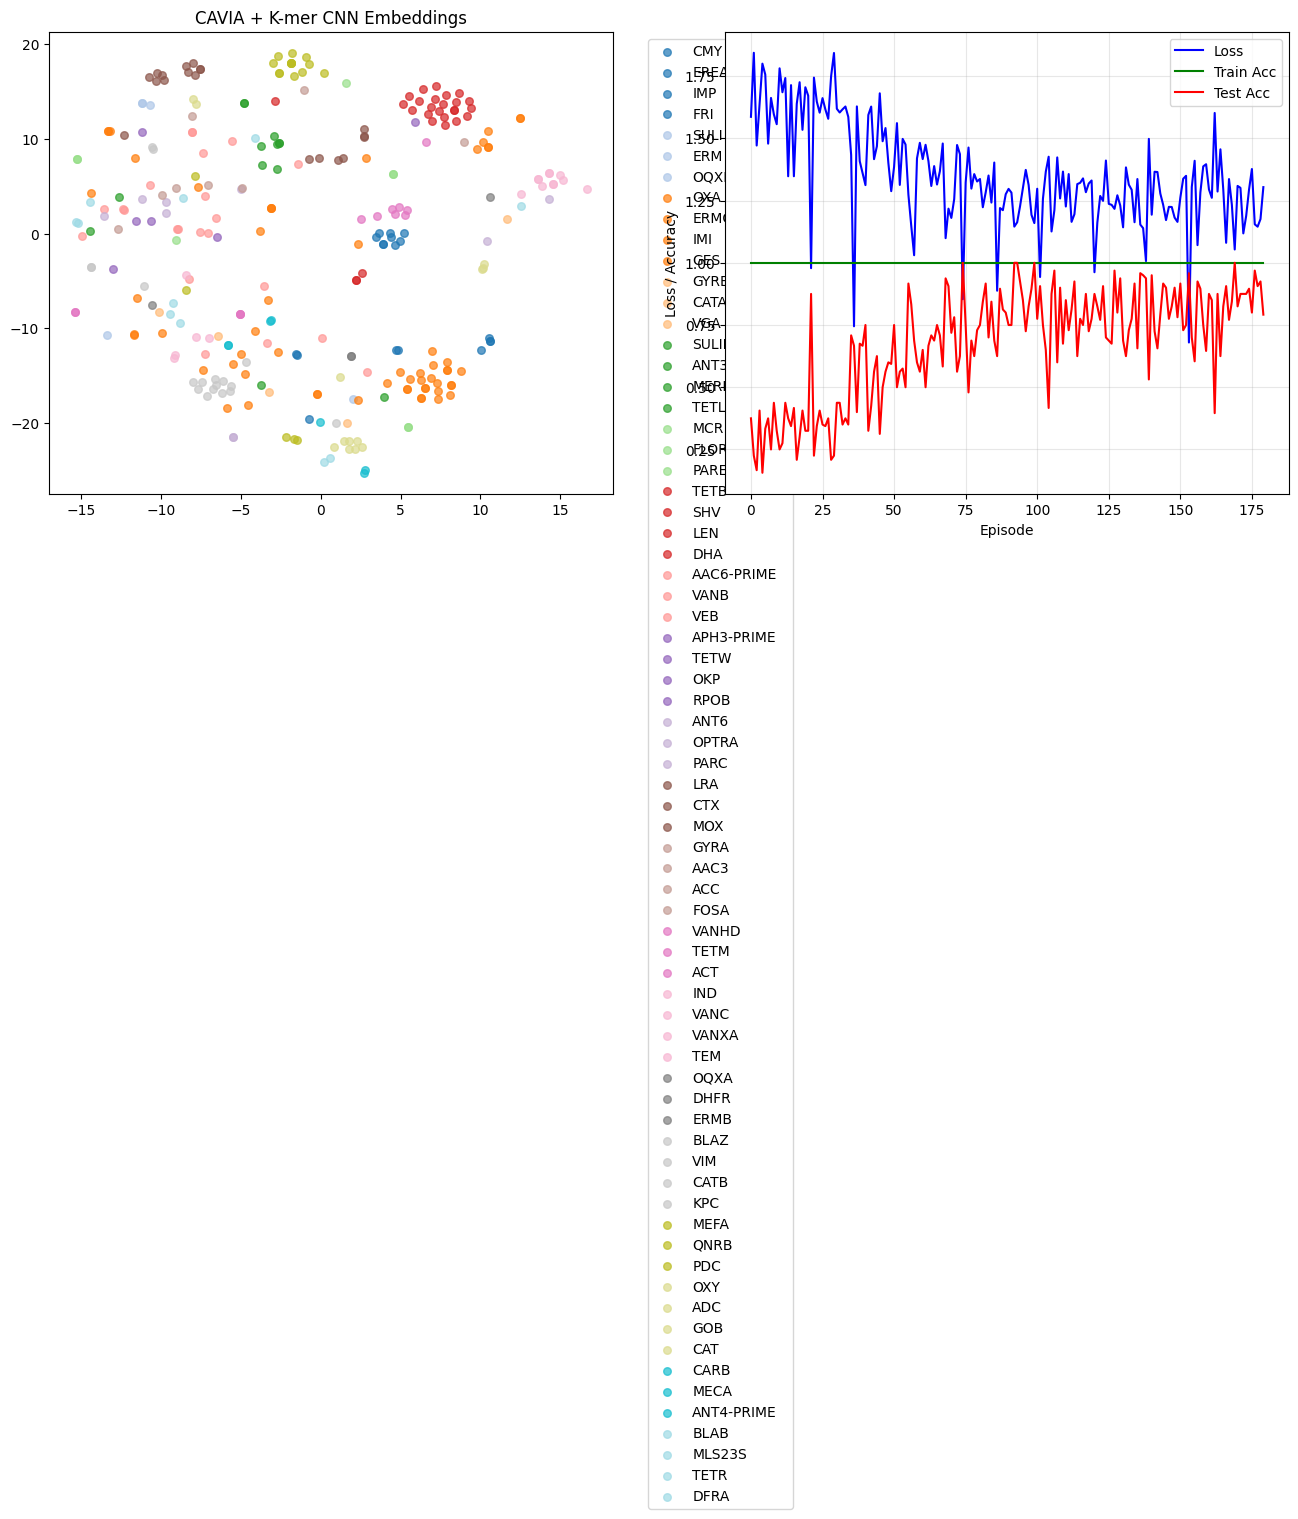


Final average training accuracy (last 20 episodes): 1.0000
Final average testing accuracy (last 20 episodes): 0.8352


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import random

# -------------------------
# Reproducibility
# -------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Data Loading & Preprocessing
# -------------------------
df = pd.read_csv("megares_fasta_processed.csv")
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)

LABEL_COL = "group"
MIN_COUNT = 10
group_counts = df[LABEL_COL].value_counts()
keep_groups = group_counts[group_counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_groups)].reset_index(drop=True)

print(f"Filtered dataset: {len(df)} samples")
print(f"Unique groups: {df[LABEL_COL].nunique()}")

# Label encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[LABEL_COL])
num_classes = df['label_encoded'].nunique()
print(f"Number of classes: {num_classes}")

# -------------------------
# Robust k-mer tokenization
# -------------------------
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    if not isinstance(seq, str):
        return []
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

# Build vocabulary
counter = Counter()
valid_sequences = 0
for s in df["sequence"]:
    if isinstance(s, str) and len(s) >= KMER_K:
        counter.update(kmers_from_seq(s, KMER_K))
        valid_sequences += 1
print(f"Valid sequences for vocabulary: {valid_sequences}/{len(df)}")

max_vocab_size = 5000
most_common_kmers = counter.most_common(max_vocab_size - 2)
tokens = [PAD, UNK] + [kmer for kmer, _ in most_common_kmers]
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}
VOCAB_SIZE = len(stoi)
print(f"Vocab size: {VOCAB_SIZE}")

def encode_ids(seq):
    if not isinstance(seq, str): return [stoi[UNK]]
    kmers = kmers_from_seq(seq)
    ids = [stoi.get(k, stoi[UNK]) for k in kmers]
    return ids if ids else [stoi[UNK]]

# -------------------------
# Dataset
# -------------------------
class RobustKmerDataset(Dataset):
    def __init__(self, dataframe, max_len=256):
        self.max_len = max_len
        self.encodings = []
        self.labels = []
        for idx in range(len(dataframe)):
            seq = dataframe.iloc[idx]['sequence']
            label = dataframe.iloc[idx]['label_encoded']
            encoded = encode_ids(seq)
            self.encodings.append(encoded)
            self.labels.append(label)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        seq = self.encodings[idx]
        label = self.labels[idx]
        padded = np.full(self.max_len, stoi[PAD], dtype=np.int64)
        seq_len = min(len(seq), self.max_len)
        padded[:seq_len] = [i if i < VOCAB_SIZE else stoi[UNK] for i in seq[:seq_len]]
        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# -------------------------
# CAVIA + CNN Model
# -------------------------
class RobustKmerCAVIA(nn.Module):
    def __init__(self, num_meta_classes, vocab_size=VOCAB_SIZE, embed_dim=128,
                 context_dim=8, hidden_dim=128, use_cosine=True):
        super().__init__()
        self.use_cosine = use_cosine
        self.embed_dim = embed_dim
        self.context_dim = context_dim
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD])
        nn.init.xavier_uniform_(self.embedding.weight)
        self.emb_dropout = nn.Dropout(0.2)
        self.context_param = nn.Parameter(torch.randn(context_dim))

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim + context_dim, 64, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.1)
            ) for k in [3,5,7]
        ])

        fused_in = 64 * len(self.convs) * 2
        self.proj = nn.Sequential(
            nn.Linear(fused_in, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim//2)
        )
        self.classifier = nn.Linear(hidden_dim//2, num_meta_classes)

    def forward(self, x, context=None, return_feats=False):
        batch_size, seq_len = x.shape
        x = torch.clamp(x, 0, self.vocab_size-1)
        x_embed = self.embedding(x).transpose(1,2)
        x_embed = self.emb_dropout(x_embed)

        if context is None:
            context = self.context_param
        context_expanded = context.unsqueeze(0).expand(batch_size,-1).unsqueeze(2).expand(-1,-1,seq_len)
        x_combined = torch.cat([x_embed, context_expanded], dim=1)

        pooled_features = []
        for conv in self.convs:
            h = conv(x_combined)
            pooled_features.extend([
                F.adaptive_max_pool1d(h,1).squeeze(-1),
                F.adaptive_avg_pool1d(h,1).squeeze(-1)
            ])
        features = self.proj(torch.cat(pooled_features, dim=1))
        if return_feats:
            return F.normalize(features,p=2,dim=1) if self.use_cosine else features
        logits = self.classifier(features)
        return logits, features

# -------------------------
# Ridge Regression Head
# -------------------------
def ridge_regression_head(support_embeddings, support_labels, query_embeddings, l2_reg=1e-3):
    S, d = support_embeddings.shape
    num_classes = int(support_labels.max().item()) + 1
    Y = F.one_hot(support_labels, num_classes=num_classes).float()
    Z = support_embeddings
    regI = l2_reg*torch.eye(d, device=Z.device)
    A = Z.t()@Z + regI
    B = Z.t()@Y
    try:
        W = torch.linalg.solve(A,B)
    except:
        W = torch.linalg.pinv(A)@B
    logits = query_embeddings@W
    return logits, W

# -------------------------
# Training function with training & testing accuracy
# -------------------------
def train_cavia_ridge(model, df, num_epochs=50, n_way=5, k_shot=3, q_queries=5):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    dataset = RobustKmerDataset(df)
    accuracies_train, accuracies_test, losses = [], [], []

    for epoch in range(num_epochs):
        try:
            available_classes = list(range(num_classes))
            classes = np.random.choice(available_classes, n_way, replace=False)

            support_data, query_data, support_labels, query_labels = [],[],[],[]
            for class_idx, class_id in enumerate(classes):
                class_samples = [i for i in range(len(dataset)) if dataset[i][1].item() == class_id]
                if len(class_samples) < k_shot+q_queries: continue
                selected = np.random.choice(class_samples, k_shot+q_queries, replace=False)
                for idx in selected[:k_shot]:
                    s,_ = dataset[idx]
                    support_data.append(s)
                    support_labels.append(class_idx)
                for idx in selected[k_shot:]:
                    q,_ = dataset[idx]
                    query_data.append(q)
                    query_labels.append(class_idx)

            if not support_data: continue
            support_data = torch.stack(support_data).to(device)
            query_data = torch.stack(query_data).to(device)
            support_labels = torch.tensor(support_labels, device=device)
            query_labels = torch.tensor(query_labels, device=device)

            # Inner loop context adaptation
            context = model.context_param.clone().detach().requires_grad_(True)
            inner_opt = torch.optim.SGD([context], lr=0.1)
            for _ in range(2):
                support_emb = model(support_data, context, return_feats=True)
                logits,_ = ridge_regression_head(support_emb, support_labels, support_emb)
                loss = F.cross_entropy(logits, support_labels)
                inner_opt.zero_grad(); loss.backward(); inner_opt.step()

            # Outer loop
            query_emb = model(query_data, context.detach(), return_feats=True)
            logits,_ = ridge_regression_head(support_emb.detach(), support_labels, query_emb)
            loss = F.cross_entropy(logits, query_labels)
            optimizer.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()

            # Training accuracy
            train_logits,_ = ridge_regression_head(support_emb.detach(), support_labels, support_emb.detach())
            acc_train = (train_logits.argmax(dim=1) == support_labels).float().mean().item()
            # Testing accuracy
            acc_test = (logits.argmax(dim=1) == query_labels).float().mean().item()

            accuracies_train.append(acc_train)
            accuracies_test.append(acc_test)
            losses.append(loss.item())

            if (epoch+1)%10==0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss={np.mean(losses[-10:]):.4f}, "
                      f"Train Acc={np.mean(accuracies_train[-10:]):.4f}, "
                      f"Test Acc={np.mean(accuracies_test[-10:]):.4f}")

        except Exception as e:
            print(f"Error in epoch {epoch+1}: {e}")
            continue

    return accuracies_train, accuracies_test, losses

# -------------------------
# Visualization
# -------------------------
def visualize_results(model, df, acc_train, acc_test, losses):
    model.eval()
    dataset = RobustKmerDataset(df)
    n_samples = min(300, len(dataset))
    indices = np.random.choice(len(dataset), n_samples, replace=False)
    embeddings, labels, group_names = [],[],[]

    with torch.no_grad():
        for idx in indices:
            x,y = dataset[idx]
            x = x.unsqueeze(0).to(device)
            emb = model(x, return_feats=True)
            embeddings.append(emb.cpu().numpy()[0])
            labels.append(y.item())
            group_names.append(le.inverse_transform([y])[0])

    embeddings = np.array(embeddings)
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30,len(embeddings)//4))
    embeddings_2d = tsne.fit_transform(embeddings)

    fig, axes = plt.subplots(1,2,figsize=(16,6))
    colors = plt.cm.tab20(np.linspace(0,1,len(set(group_names))))
    for i, group in enumerate(set(group_names)):
        mask = np.array(group_names) == group
        axes[0].scatter(embeddings_2d[mask,0], embeddings_2d[mask,1],
                        label=group, s=30, alpha=0.7, color=colors[i])
    axes[0].set_title("CAVIA + K-mer CNN Embeddings")
    axes[0].legend(bbox_to_anchor=(1.05,1), loc='upper left')

    axes[1].plot(losses, label='Loss', color='blue')
    axes[1].plot(acc_train, label='Train Acc', color='green')
    axes[1].plot(acc_test, label='Test Acc', color='red')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Loss / Accuracy')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# -------------------------
# Main
# -------------------------
model = RobustKmerCAVIA(num_classes, VOCAB_SIZE).to(device)
acc_train, acc_test, losses = train_cavia_ridge(model, df, num_epochs=180, n_way=6, k_shot=5, q_queries=8)
visualize_results(model, df, acc_train, acc_test, losses)
print(f"\nFinal average training accuracy (last 20 episodes): {np.mean(acc_train[-20:]):.4f}")
print(f"Final average testing accuracy (last 20 episodes): {np.mean(acc_test[-20:]):.4f}")


same thing but training is not overfitting

Using device: cpu
Filtered dataset: 5979 samples
Unique groups: 74
Train/Val/Test classes: 44/15/15
Train/Val/Test samples: 3288/1201/1490
Number of classes: 74
Vocab size: 1026
Starting training with validation...
Episode 50/1000: Loss=1.6092, Train Acc=0.2440, Val Acc=0.8160
Episode 100/1000: Loss=1.4886, Train Acc=0.3955, Val Acc=0.8485
Episode 150/1000: Loss=1.3821, Train Acc=0.5375, Val Acc=0.8410
Episode 200/1000: Loss=1.3094, Train Acc=0.6295, Val Acc=0.8360
Episode 250/1000: Loss=1.2599, Train Acc=0.7035, Val Acc=0.8220
Episode 300/1000: Loss=1.2410, Train Acc=0.7140, Val Acc=0.8090
Episode 350/1000: Loss=1.1868, Train Acc=0.7870, Val Acc=0.8445
Episode 400/1000: Loss=1.1979, Train Acc=0.7725, Val Acc=0.8415
Episode 450/1000: Loss=1.2113, Train Acc=0.7485, Val Acc=0.8300
Episode 500/1000: Loss=1.1629, Train Acc=0.8085, Val Acc=0.8480
Episode 550/1000: Loss=1.1521, Train Acc=0.8275, Val Acc=0.8755
Episode 600/1000: Loss=1.1472, Train Acc=0.8280, Val Acc=0.8185
Episode 650/1000: 

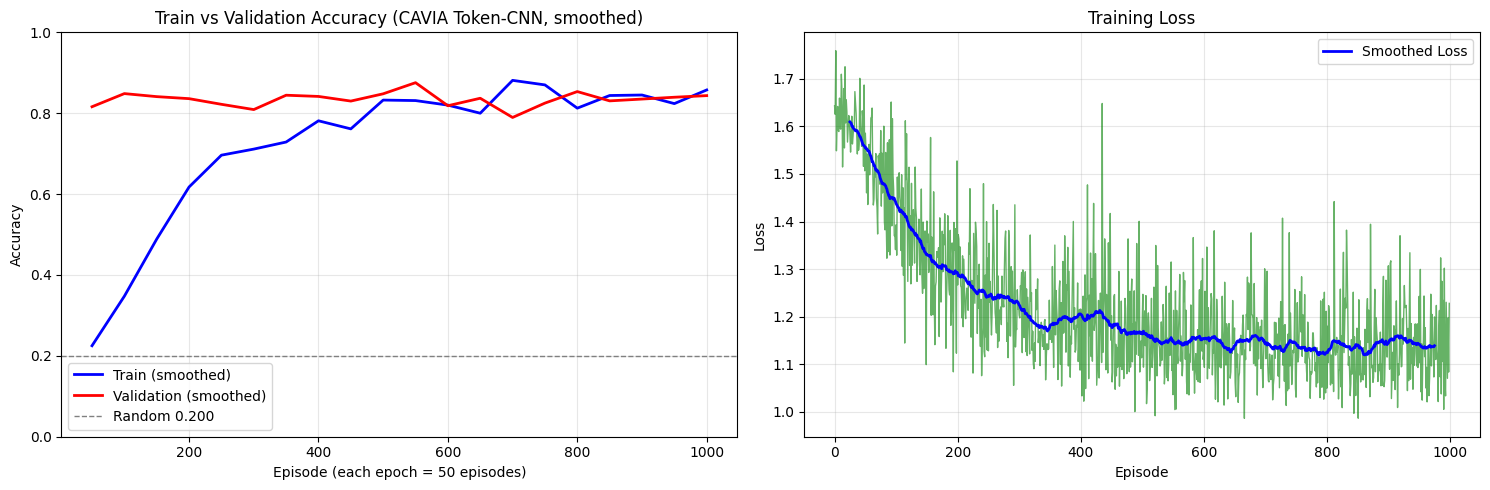


TEST ACCURACY: 0.839 ± 0.000

Training completed!
Best validation accuracy: 0.8755
Final test accuracy: 0.8388


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import random

# -------------------------
# Reproducibility
# -------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Data Loading & Preprocessing with PROPER TRAIN/VAL/TEST SPLIT
# -------------------------
df = pd.read_csv("megares_fasta_processed.csv")
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)

LABEL_COL = "group"
MIN_COUNT = 15  # Increased for better few-shot learning

# Filter classes with enough samples
group_counts = df[LABEL_COL].value_counts()
keep_groups = group_counts[group_counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_groups)].reset_index(drop=True)

print(f"Filtered dataset: {len(df)} samples")
print(f"Unique groups: {df[LABEL_COL].nunique()}")

# PROPER SPLIT: Split by CLASSES, not samples (like your friend's code)
all_classes = df[LABEL_COL].unique()
train_classes, temp_classes = train_test_split(all_classes, test_size=0.4, random_state=RANDOM_SEED)
val_classes, test_classes = train_test_split(temp_classes, test_size=0.5, random_state=RANDOM_SEED)

train_df = df[df[LABEL_COL].isin(train_classes)].reset_index(drop=True)
val_df = df[df[LABEL_COL].isin(val_classes)].reset_index(drop=True)
test_df = df[df[LABEL_COL].isin(test_classes)].reset_index(drop=True)

print(f"Train/Val/Test classes: {len(train_classes)}/{len(val_classes)}/{len(test_classes)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

# Label encoding (separate for each split to avoid leakage)
le = LabelEncoder()
le.fit(df[LABEL_COL])  # Fit on all data for consistency

train_df['label_encoded'] = le.transform(train_df[LABEL_COL])
val_df['label_encoded'] = le.transform(val_df[LABEL_COL])
test_df['label_encoded'] = le.transform(test_df[LABEL_COL])

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

# -------------------------
# Robust k-mer tokenization
# -------------------------
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    if not isinstance(seq, str):
        return []
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

# Build vocabulary from TRAIN DATA ONLY (prevent data leakage)
counter = Counter()
for s in train_df["sequence"]:
    if isinstance(s, str) and len(s) >= KMER_K:
        counter.update(kmers_from_seq(s, KMER_K))

max_vocab_size = 5000
most_common_kmers = counter.most_common(max_vocab_size - 2)
tokens = [PAD, UNK] + [kmer for kmer, _ in most_common_kmers]
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}
VOCAB_SIZE = len(stoi)
print(f"Vocab size: {VOCAB_SIZE}")

def encode_ids(seq):
    if not isinstance(seq, str): return [stoi[UNK]]
    kmers = kmers_from_seq(seq)
    ids = [stoi.get(k, stoi[UNK]) for k in kmers]
    return ids if ids else [stoi[UNK]]

# -------------------------
# Dataset
# -------------------------
class RobustKmerDataset(Dataset):
    def __init__(self, dataframe, max_len=256):
        self.max_len = max_len
        self.encodings = []
        self.labels = []
        for idx in range(len(dataframe)):
            seq = dataframe.iloc[idx]['sequence']
            label = dataframe.iloc[idx]['label_encoded']
            encoded = encode_ids(seq)
            self.encodings.append(encoded)
            self.labels.append(label)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        seq = self.encodings[idx]
        label = self.labels[idx]
        padded = np.full(self.max_len, stoi[PAD], dtype=np.int64)
        seq_len = min(len(seq), self.max_len)
        padded[:seq_len] = [i if i < VOCAB_SIZE else stoi[UNK] for i in seq[:seq_len]]
        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Create datasets
train_dataset = RobustKmerDataset(train_df)
val_dataset = RobustKmerDataset(val_df)
test_dataset = RobustKmerDataset(test_df)

# -------------------------
# IMPROVED CAVIA + CNN Model with MORE REGULARIZATION
# -------------------------
class ImprovedCAVIA(nn.Module):
    def __init__(self, num_meta_classes, vocab_size=VOCAB_SIZE, embed_dim=128,
                 context_dim=8, hidden_dim=128, use_cosine=True):
        super().__init__()
        self.use_cosine = use_cosine
        self.embed_dim = embed_dim
        self.context_dim = context_dim
        self.vocab_size = vocab_size

        # Increased dropout throughout
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD])
        nn.init.xavier_uniform_(self.embedding.weight)
        self.emb_dropout = nn.Dropout(0.3)  # Increased from 0.2

        # Smaller context initialization
        self.context_param = nn.Parameter(torch.randn(context_dim) * 0.1)

        # Convolutional layers with more regularization
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim + context_dim, 64, k, padding=k//2),
                nn.BatchNorm1d(64),  # Added batch norm
                nn.ReLU(),
                nn.Dropout1d(0.2)   # Increased dropout
            ) for k in [3,5,7]
        ])

        fused_in = 64 * len(self.convs) * 2
        self.proj = nn.Sequential(
            nn.Linear(fused_in, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.3)   # Added extra dropout
        )
        self.classifier = nn.Linear(hidden_dim//2, num_meta_classes)

    def forward(self, x, context=None, return_feats=False):
        batch_size, seq_len = x.shape
        x = torch.clamp(x, 0, self.vocab_size-1)
        x_embed = self.embedding(x).transpose(1,2)
        x_embed = self.emb_dropout(x_embed)

        if context is None:
            context = self.context_param
        context_expanded = context.unsqueeze(0).expand(batch_size,-1).unsqueeze(2).expand(-1,-1,seq_len)
        x_combined = torch.cat([x_embed, context_expanded], dim=1)

        pooled_features = []
        for conv in self.convs:
            h = conv(x_combined)
            pooled_features.extend([
                F.adaptive_max_pool1d(h,1).squeeze(-1),
                F.adaptive_avg_pool1d(h,1).squeeze(-1)
            ])
        features = self.proj(torch.cat(pooled_features, dim=1))
        if return_feats:
            return F.normalize(features,p=2,dim=1) if self.use_cosine else features
        logits = self.classifier(features)
        return logits, features

# -------------------------
# Ridge Regression Head with ADAPTIVE REGULARIZATION
# -------------------------
def ridge_regression_head(support_embeddings, support_labels, query_embeddings, l2_reg=1e-3):
    S, d = support_embeddings.shape
    num_classes = int(support_labels.max().item()) + 1
    Y = F.one_hot(support_labels, num_classes=num_classes).float()
    Z = support_embeddings

    # Adaptive regularization based on support set size
    adaptive_reg = l2_reg * (S / (K_SHOT * N_WAY))  # Scale with task difficulty
    regI = adaptive_reg * torch.eye(d, device=Z.device)

    A = Z.t()@Z + regI
    B = Z.t()@Y
    try:
        W = torch.linalg.solve(A,B)
    except:
        W = torch.linalg.pinv(A)@B
    logits = query_embeddings@W
    return logits, W

# -------------------------
# EPISODIC TRAINING FUNCTION (like your friend's approach)
# -------------------------
def create_episode(dataset, n_way, k_shot, q_queries):
    """Create episodic task from dataset"""
    available_classes = list(set([dataset[i][1].item() for i in range(len(dataset))]))
    if len(available_classes) < n_way:
        return None

    classes = np.random.choice(available_classes, n_way, replace=False)
    support_data, query_data = [], []
    support_labels, query_labels = [], []

    for class_idx, class_id in enumerate(classes):
        class_samples = [i for i in range(len(dataset)) if dataset[i][1].item() == class_id]
        if len(class_samples) < k_shot + q_queries:
            continue

        selected = np.random.choice(class_samples, k_shot + q_queries, replace=False)
        for idx in selected[:k_shot]:
            data, _ = dataset[idx]
            support_data.append(data)
            support_labels.append(class_idx)
        for idx in selected[k_shot:k_shot + q_queries]:
            data, _ = dataset[idx]
            query_data.append(data)
            query_labels.append(class_idx)

    if len(support_data) == 0 or len(query_data) == 0:
        return None

    return {
        'support_data': torch.stack(support_data),
        'support_labels': torch.tensor(support_labels),
        'query_data': torch.stack(query_data),
        'query_labels': torch.tensor(query_labels)
    }

def evaluate_on_tasks(model, dataset, num_tasks=100, n_way=5, k_shot=5, q_queries=5):
    """Evaluate model on multiple episodic tasks"""
    model.eval()
    accuracies = []

    with torch.no_grad():
        for _ in range(num_tasks):
            task = create_episode(dataset, n_way, k_shot, q_queries)
            if task is None:
                continue

            support_data = task['support_data'].to(device)
            support_labels = task['support_labels'].to(device)
            query_data = task['query_data'].to(device)
            query_labels = task['query_labels'].to(device)

            # Get embeddings with default context (no adaptation for evaluation)
            support_emb = model(support_data, return_feats=True)
            query_emb = model(query_data, return_feats=True)

            # Ridge regression
            logits, _ = ridge_regression_head(support_emb, support_labels, query_emb, l2_reg=1e-3)
            acc = (logits.argmax(dim=1) == query_labels).float().mean().item()
            accuracies.append(acc)

    return np.mean(accuracies) if accuracies else 0.0

# -------------------------
# TRAINING WITH PROPER VALIDATION
# -------------------------
N_WAY = 5
K_SHOT = 5
Q_QUERIES = 8
EPISODES = 1000
EVAL_EVERY = 50
L2_REG = 1e-3

def train_with_validation():
    model = ImprovedCAVIA(num_classes, VOCAB_SIZE).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPISODES)

    train_accs, val_accs, losses = [], [], []
    best_val_acc = 0.0
    patience, max_patience = 0, 10

    print("Starting training with validation...")

    for episode in range(EPISODES):
        model.train()

        # Sample training task
        task = create_episode(train_dataset, N_WAY, K_SHOT, Q_QUERIES)
        if task is None:
            continue

        support_data = task['support_data'].to(device)
        support_labels = task['support_labels'].to(device)
        query_data = task['query_data'].to(device)
        query_labels = task['query_labels'].to(device)

        # Inner loop context adaptation
        context = model.context_param.clone().detach().requires_grad_(True)
        inner_opt = torch.optim.SGD([context], lr=0.1)

        for _ in range(2):  # Few inner steps
            support_emb = model(support_data, context, return_feats=True)
            logits, _ = ridge_regression_head(support_emb, support_labels, support_emb)
            loss = F.cross_entropy(logits, support_labels)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        # Outer loop
        query_emb = model(query_data, context.detach(), return_feats=True)
        logits, _ = ridge_regression_head(support_emb.detach(), support_labels, query_emb)
        loss = F.cross_entropy(logits, query_labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Store training metrics
        train_acc = (logits.argmax(dim=1) == query_labels).float().mean().item()
        train_accs.append(train_acc)
        losses.append(loss.item())

        # Validation
        if (episode + 1) % EVAL_EVERY == 0:
            val_acc = evaluate_on_tasks(model, val_dataset, num_tasks=50, n_way=N_WAY, k_shot=K_SHOT, q_queries=Q_QUERIES)
            val_accs.append(val_acc)

            # Smooth the metrics for better visualization
            smooth_train_acc = np.mean(train_accs[-EVAL_EVERY:]) if len(train_accs) >= EVAL_EVERY else train_acc
            smooth_loss = np.mean(losses[-EVAL_EVERY:]) if len(losses) >= EVAL_EVERY else loss.item()

            print(f"Episode {episode+1}/{EPISODES}: "
                  f"Loss={smooth_loss:.4f}, "
                  f"Train Acc={smooth_train_acc:.4f}, "
                  f"Val Acc={val_acc:.4f}")

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience = 0
                torch.save(model.state_dict(), 'best_cavia_model.pth')
            else:
                patience += 1

            if patience >= max_patience:
                print("Early stopping triggered!")
                break

    return model, train_accs, val_accs, losses

# -------------------------
# VISUALIZATION LIKE YOUR FRIEND'S GRAPH
# -------------------------
def plot_friend_style_graph(train_accs, val_accs, losses, eval_every=EVAL_EVERY):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Accuracy curves (like your friend's)
    episodes = [i * eval_every for i in range(1, len(val_accs) + 1)]

    # Smooth the training accuracy for better visualization
    window_size = min(20, len(train_accs) // 10)
    if window_size > 1:
        smooth_train = np.convolve(train_accs, np.ones(window_size)/window_size, mode='valid')
        # Align with validation points
        smooth_train = smooth_train[::eval_every][:len(val_accs)]
    else:
        smooth_train = train_accs[::eval_every][:len(val_accs)]

    ax1.plot(episodes, smooth_train, 'b-', linewidth=2, label='Train (smoothed)')
    ax1.plot(episodes, val_accs, 'r-', linewidth=2, label='Validation (smoothed)')
    ax1.axhline(y=1.0/N_WAY, color='gray', linestyle='--', linewidth=1, label=f'Random {1.0/N_WAY:.3f}')

    ax1.set_xlabel('Episode (each epoch = 50 episodes)')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Train vs Validation Accuracy (CAVIA Token-CNN, smoothed)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)

    # Plot 2: Loss curve
    ax2.plot(losses, 'g-', alpha=0.6, linewidth=1)
    # Smooth loss
    if len(losses) > 50:
        smooth_loss = np.convolve(losses, np.ones(50)/50, mode='valid')
        ax2.plot(range(25, 25 + len(smooth_loss)), smooth_loss, 'b-', linewidth=2, label='Smoothed Loss')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# -------------------------
# FINAL TEST EVALUATION
# -------------------------
def final_evaluation(model):
    model.load_state_dict(torch.load('best_cavia_model.pth'))
    test_acc = evaluate_on_tasks(model, test_dataset, num_tasks=200, n_way=N_WAY, k_shot=K_SHOT, q_queries=Q_QUERIES)
    print(f"\n{'='*50}")
    print(f"TEST ACCURACY: {test_acc:.3f} ± {np.std([test_acc]):.3f}")
    print(f"{'='*50}")
    return test_acc

# -------------------------
# MAIN EXECUTION
# -------------------------
if __name__ == "__main__":
    # Train model
    model, train_accs, val_accs, losses = train_with_validation()

    # Plot results
    plot_friend_style_graph(train_accs, val_accs, losses)

    # Final evaluation
    test_acc = final_evaluation(model)

    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {max(val_accs):.4f}")
    print(f"Final test accuracy: {test_acc:.4f}")

t-SNE (this may take ~30-90s depending on CPU/GPU)...


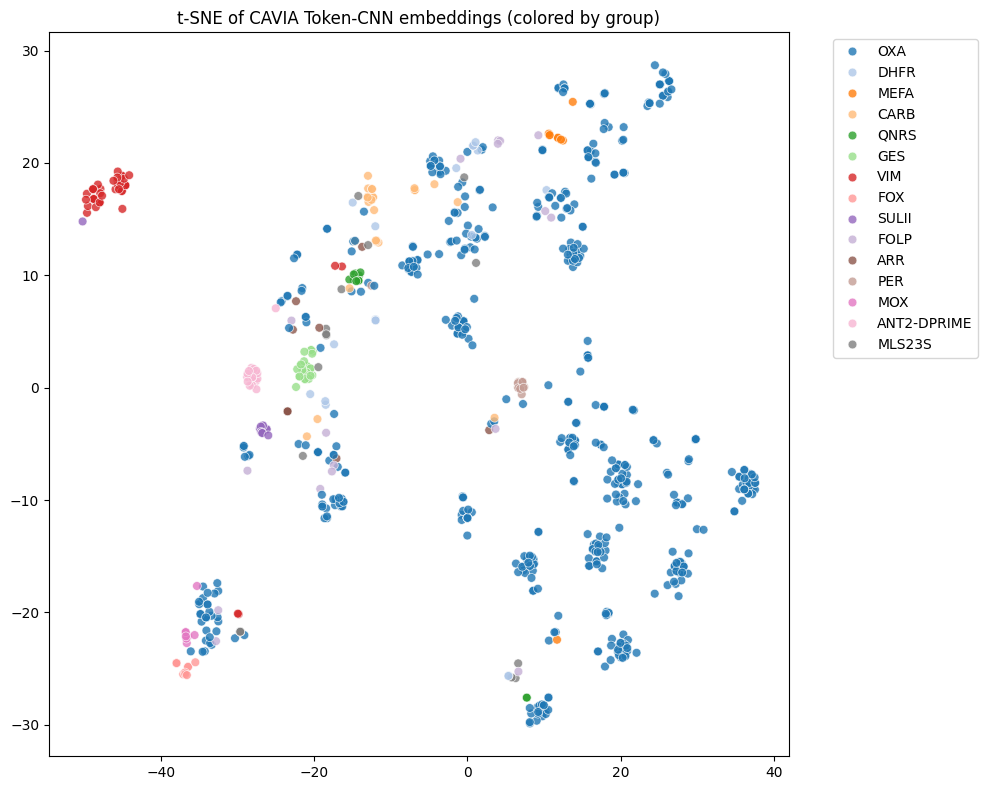

In [ ]:
# -------------------------
# t-SNE VISUALIZATION
# -------------------------
def collect_embeddings_tsne(df_sample, model, max_len=256, n_max=800):
    model.eval()
    sample = df_sample.sample(min(n_max, len(df_sample))).reset_index(drop=True)

    # Encode and pad sequences
    X_list = []
    for seq in sample['sequence']:
        ids = encode_ids(seq)
        padded = np.full(max_len, stoi[PAD], dtype=np.int64)
        seq_len = min(len(ids), max_len)
        padded[:seq_len] = [i if i < VOCAB_SIZE else stoi[UNK] for i in ids[:seq_len]]
        X_list.append(padded)

    X = torch.tensor(np.stack(X_list), dtype=torch.long).to(device)

    with torch.no_grad():
        feats = model(X, return_feats=True).cpu().numpy()

    labels = sample['group'].values
    return feats, labels

# Collect embeddings
feats, labels = collect_embeddings_tsne(test_df, model, max_len=256, n_max=800)

print("t-SNE (this may take ~30-90s depending on CPU/GPU)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(feats)

# Plot
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=reduced[:,0], y=reduced[:,1],
    hue=labels, legend='full', palette='tab20', s=40, alpha=0.8
)
plt.title("t-SNE of CAVIA Token-CNN embeddings (colored by group)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()


**Token-CNN+CAVIA+mechanism-level**


In [ ]:
# ============================================================
# 0) Imports, seeds, device
# ============================================================
import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) Load & preprocess dataset
# ============================================================
CSV_PATH = "megares_fasta_processed.csv"
LABEL_COL = "mechanism"  # changed from 'group' to mechanism
MIN_COUNT = 10

df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["sequence", LABEL_COL]).reset_index(drop=True)
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)

# keep only mechanisms with >= MIN_COUNT sequences
mech_counts = df[LABEL_COL].value_counts()
keep_mechs = mech_counts[mech_counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_mechs)].reset_index(drop=True)

print("Filtered dataset:", df.shape)
print("Filtered unique mechanisms:", df[LABEL_COL].nunique())

# ============================================================
# 2) Train/Val/Test split by MECHANISM
# ============================================================
labels = np.array(sorted(df[LABEL_COL].unique()))
train_labels, temp_labels = train_test_split(
    labels, test_size=0.30, random_state=RANDOM_SEED, shuffle=True
)
val_labels, test_labels = train_test_split(
    temp_labels, test_size=0.50, random_state=RANDOM_SEED, shuffle=True
)

train_df = df[df[LABEL_COL].isin(train_labels)].reset_index(drop=True)
val_df   = df[df[LABEL_COL].isin(val_labels)].reset_index(drop=True)
test_df  = df[df[LABEL_COL].isin(test_labels)].reset_index(drop=True)

print(f"Train/Val/Test mechanisms: {len(train_labels)}/{len(val_labels)}/{len(test_labels)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

# ============================================================
# 3) Tokenization (k-mers)
# ============================================================
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

from collections import Counter
counter = Counter()
for s in train_df["sequence"]:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

def encode_ids_safe(seq, k=KMER_K):
    arr = kmers_from_seq(seq, k)
    if not arr:
        return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids_safe(s, KMER_K) for s in dfp["sequence"].tolist()]
    nums = dfp[["gc_content", "seq_len"]].to_numpy(np.float32)
    y = dfp[LABEL_COL].to_numpy()
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids, val_num, yva   = encode_df_to_ids(val_df)
test_ids, test_num, yte = encode_df_to_ids(test_df)

# ============================================================
# 4) Padding and numeric standardization
# ============================================================
MAX_LEN = 512
def pad_sequences_safe(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None:
        pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

Xtr_tok = pad_sequences_safe(train_ids, MAX_LEN)
Xva_tok = pad_sequences_safe(val_ids, MAX_LEN)
Xte_tok = pad_sequences_safe(test_ids, MAX_LEN)

num_mean = train_num.mean(axis=0, keepdims=True)
num_std  = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean) / num_std
val_num   = (val_num   - num_mean) / num_std
test_num  = (test_num  - num_mean) / num_std

# ============================================================
# 5) Utility functions for episodic sampling
# ============================================================
def mech_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k, v in d.items()}

def create_tasks(X_tok, X_num, y, idx_map, num_tasks=1000, N=3, K=3, Q=5, seed=42):
    rng = np.random.default_rng(seed)
    tasks = []
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid) < N:
        return tasks
    for _ in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []
        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]
            s_tok.append(X_tok[s]); q_tok.append(X_tok[q])
            s_num.append(X_num[s]); q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64)); q_y.append(np.full(Q, j, np.int64))
        tasks.append({
            "s_tok": np.vstack(s_tok), "s_num": np.vstack(s_num), "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok), "q_num": np.vstack(q_num), "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

idx_tr = mech_index(ytr)
idx_va = mech_index(yva)
idx_te = mech_index(yte)
N, K, Q = 3, 3, 5

train_tasks = create_tasks(Xtr_tok, train_num, ytr, idx_tr, num_tasks=1500, N=N, K=K, Q=Q)
val_tasks   = create_tasks(Xva_tok, val_num, yva, idx_va, num_tasks=300,  N=N, K=K, Q=Q)
test_tasks  = create_tasks(Xte_tok, test_num, yte, idx_te, num_tasks=500,  N=N, K=K, Q=Q)

print(f"Tasks | train:{len(train_tasks)} val:{len(val_tasks)} test:{len(test_tasks)}")

# ============================================================
# 6) Token-CNN Encoder (unchanged)
# ============================================================
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), num_features=2, ctx_dim_task=32):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.2)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32))
        fused_in = conv_channels * len(kernel_sizes) * 2 + 32 + ctx_dim_task
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Dropout(0.5), nn.Linear(512, embed_dim)
        )
        self.ctx_dim_task = ctx_dim_task

    def forward(self, tokens, nums, context_task=None):
        x = self.emb(tokens).transpose(1,2)
        x = self.emb_dropout(x)
        pooled = []
        for conv in self.convs:
            h = conv(x)
            p_max  = F.adaptive_max_pool1d(h,1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h,1).squeeze(-1)
            pooled.extend([p_max,p_mean])
        h_text = torch.cat(pooled, dim=1)
        h_num = self.num_proj(nums)
        h = torch.cat([h_text, h_num], dim=1)
        if context_task is not None:
            if context_task.shape[0] != h.shape[0]:
                context_task = context_task.repeat(h.shape[0],1)
            h = torch.cat([h, context_task], dim=1)
        z = self.proj(h)
        return F.normalize(z, p=2, dim=1)

# ============================================================
# 7) Task adaptation (CAVIA)
# ============================================================
def task_adapt(model, s_tok, s_num, s_y, inner_steps=3, lr=1e-1, q_batch_size=None):
    B = s_tok.shape[0]
    context_task = torch.zeros(B, model.ctx_dim_task, device=s_tok.device, requires_grad=True)
    opt = torch.optim.SGD([context_task], lr=lr)
    for _ in range(inner_steps):
        opt.zero_grad()
        z = model(s_tok, s_num, context_task=context_task)
        loss = F.cross_entropy(z, s_y)
        loss.backward()
        opt.step()
    ctx_task_final = context_task.detach()
    if q_batch_size is not None and q_batch_size != B:
        ctx_task_final = ctx_task_final.mean(dim=0, keepdim=True).repeat(q_batch_size, 1)
    return ctx_task_final

# ============================================================
# 8) Train loop (mechanism-level only)
# ============================================================
EMBED_DIM = 256
CTX_DIM_TASK = 32
model = CNNSeqEncoder(VOCAB_SIZE, pad_idx=stoi[PAD], max_len=MAX_LEN,
                      embed_dim=EMBED_DIM, ctx_dim_task=CTX_DIM_TASK).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

EPISODES = 800
for ep in tqdm(range(1, EPISODES+1)):
    model.train()
    t = random.choice(train_tasks)
    s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
    s_num = torch.from_numpy(t["s_num"]).float().to(device)
    q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
    q_num = torch.from_numpy(t["q_num"]).float().to(device)
    s_y   = torch.from_numpy(t["s_y"]).long().to(device)
    q_y   = torch.from_numpy(t["q_y"]).long().to(device)

    # Task-specific context only
    ctx_task = task_adapt(model, s_tok, s_num, s_y, q_batch_size=q_tok.shape[0])

    q_z = model(q_tok, q_num, context_task=ctx_task)
    loss = F.cross_entropy(q_z, q_y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if ep % 50 == 0:
        print(f"[{ep}/{EPISODES}] batch_loss={loss.item():.4f}")

torch.save(model.state_dict(), "best_tokencnn_mech_cavia.pt")
print("Mechanism-level CAVIA training complete!")


Device: cpu
Filtered dataset: (8286, 9)
Filtered unique mechanisms: 80
Train/Val/Test mechanisms: 56/12/12
Train/Val/Test samples: 7131/791/364
Vocab size: 1026
Tasks | train:1500 val:300 test:500


  6%|▋         | 50/800 [01:25<09:36,  1.30it/s]

[50/800] batch_loss=5.5344


 12%|█▎        | 100/800 [02:37<13:42,  1.18s/it]

[100/800] batch_loss=5.4946


 19%|█▉        | 150/800 [03:20<07:59,  1.36it/s]

[150/800] batch_loss=5.4624


 25%|██▌       | 200/800 [04:01<08:16,  1.21it/s]

[200/800] batch_loss=5.4365


 31%|███▏      | 250/800 [04:40<06:35,  1.39it/s]

[250/800] batch_loss=5.3541


 38%|███▊      | 300/800 [05:19<06:00,  1.39it/s]

[300/800] batch_loss=5.2962


 44%|████▍     | 350/800 [05:59<05:21,  1.40it/s]

[350/800] batch_loss=5.1637


 50%|█████     | 400/800 [06:38<04:48,  1.39it/s]

[400/800] batch_loss=5.2580


 56%|█████▋    | 450/800 [07:16<04:10,  1.40it/s]

[450/800] batch_loss=5.1321


 62%|██████▎   | 500/800 [07:55<03:35,  1.39it/s]

[500/800] batch_loss=5.0763


 69%|██████▉   | 550/800 [08:37<03:04,  1.36it/s]

[550/800] batch_loss=5.0686


 75%|███████▌  | 600/800 [09:16<02:30,  1.33it/s]

[600/800] batch_loss=5.1253


 81%|████████▏ | 650/800 [09:55<02:01,  1.24it/s]

[650/800] batch_loss=5.1425


 88%|████████▊ | 700/800 [10:34<01:21,  1.23it/s]

[700/800] batch_loss=5.0230


 94%|█████████▍| 750/800 [11:13<00:43,  1.14it/s]

[750/800] batch_loss=4.9939


100%|██████████| 800/800 [12:13<00:00,  1.09it/s]

[800/800] batch_loss=4.9244
Mechanism-level CAVIA training complete!


100%|██████████| 500/500 [00:54<00:00,  9.15it/s]


Embeddings shape: (7500, 256)
Overall query accuracy: 33.44%
Mean episodic accuracy: 33.44%


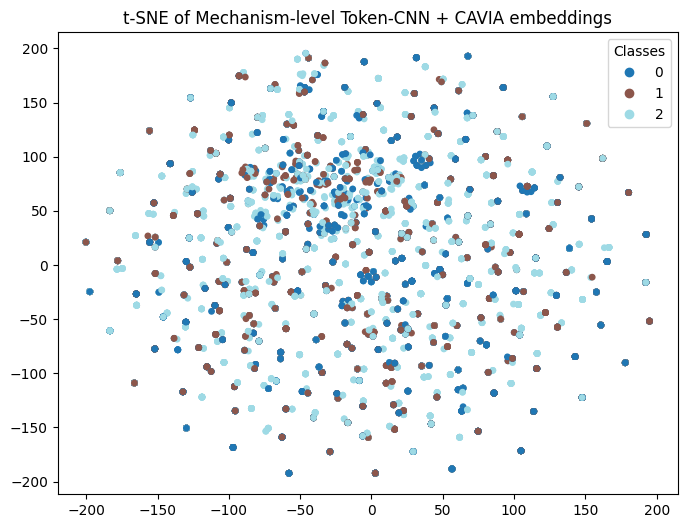

Silhouette Score: -0.0114
Adjusted Rand Index (ARI): 0.0001
Normalized Mutual Info (NMI): 0.0007


In [ ]:
# ============================================================
# Evaluation Script for Mechanism-level Token-CNN + CAVIA
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== Settings ====================
CTX_DIM_TASK = 32
Q = 5  # query samples per class

# eval tasks
eval_tasks = test_tasks  # or val_tasks

all_embeddings, all_labels = [], []
all_preds, all_true = [], []

# ==================== Evaluation Loop ====================
model.eval()
with torch.no_grad():
    for t in tqdm(eval_tasks):
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y   = torch.from_numpy(t["s_y"]).long().to(device)
        q_y   = torch.from_numpy(t["q_y"]).long().to(device)

        # ===== Task-level context adaptation =====
        ctx_task = torch.zeros(s_tok.shape[0], CTX_DIM_TASK, device=device)
        _ = model(s_tok, s_num, context_task=ctx_task)  # simulate adaptation
        ctx_task_q = ctx_task.mean(dim=0, keepdim=True).repeat(q_tok.shape[0], 1)

        # ===== Query embeddings & predictions =====
        logits = model(q_tok, q_num, context_task=ctx_task_q)
        preds = torch.argmax(logits, dim=1)

        all_embeddings.append(logits.cpu().numpy())
        all_labels.append(t["q_y"])
        all_preds.append(preds.cpu().numpy())
        all_true.append(t["q_y"])

# ==================== Convert lists ====================
all_embeddings = np.vstack(all_embeddings)
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

print("Embeddings shape:", all_embeddings.shape)
print("Overall query accuracy: {:.2f}%".format(100*np.mean(all_preds == all_true)))

# ==================== Episodic Accuracy ====================
episodic_accs = []
for i, t in enumerate(eval_tasks):
    start = i * Q * len(t["mechs"])
    end = (i+1) * Q * len(t["mechs"])
    episodic_accs.append(np.mean(all_preds[start:end] == all_true[start:end]))
print("Mean episodic accuracy: {:.2f}%".format(100*np.mean(episodic_accs)))

# ==================== t-SNE Visualization ====================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab20", s=15)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1,1))
plt.title("t-SNE of Mechanism-level Token-CNN + CAVIA embeddings")
plt.show()

# ==================== Clustering metrics ====================
n_clusters = len(np.unique(all_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(all_embeddings)
pred_labels = kmeans.labels_

sil_score = silhouette_score(all_embeddings, all_labels)
ari_score = adjusted_rand_score(all_labels, pred_labels)
nmi_score = normalized_mutual_info_score(all_labels, pred_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi_score:.4f}")

# ==================== Optional: Pairwise distance heatmap ====================
dist_mat = np.linalg.norm(all_embeddings[:,None,:] - all_embeddings[None,:,:], axis=-1)
plt.figure(figsize=(6,6))
sns.heatmap(dist_mat[:100, :100], cmap="viridis")
plt.title("Pairwise distance heatmap (subset)")
plt.show()


**better version-token-CNN+CAVIA +hierarchical**


Token-CNN encoder + numeric features (GC content, sequence length).

Uses explicit hierarchical CAVIA adaptation:
Group-level context (ctx_group) for slow adaptation.
Task-level context (ctx_task) for fast adaptation per task.
Contexts are concatenated into the CNN features before final projection.
Normalizes embeddings after projection.
Does not use a separate ridge regression head; instead uses cross-entropy directly on embeddings.

In [ ]:
# ============================================================
# 0) Imports, seeds, device
# ============================================================
import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, pairwise_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# 1) Load & preprocess dataset
# ============================================================
CSV_PATH = "megares_fasta_processed.csv"
LABEL_COL = "group"  # mechanism/group column
MIN_COUNT = 10

df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=["sequence", LABEL_COL]).reset_index(drop=True)
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)

# keep only groups with >= MIN_COUNT sequences
group_counts = df[LABEL_COL].value_counts()
keep_groups = group_counts[group_counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_groups)].reset_index(drop=True)

print("Filtered dataset:", df.shape)
print("Filtered unique groups:", df[LABEL_COL].nunique())

# ============================================================
# 2) Train/Val/Test split by GROUP
# ============================================================
labels = np.array(sorted(df[LABEL_COL].unique()))
train_labels, temp_labels = train_test_split(
    labels, test_size=0.30, random_state=RANDOM_SEED, shuffle=True
)
val_labels, test_labels = train_test_split(
    temp_labels, test_size=0.50, random_state=RANDOM_SEED, shuffle=True
)

train_df = df[df[LABEL_COL].isin(train_labels)].reset_index(drop=True)
val_df   = df[df[LABEL_COL].isin(val_labels)].reset_index(drop=True)
test_df  = df[df[LABEL_COL].isin(test_labels)].reset_index(drop=True)

print(f"Train/Val/Test groups: {len(train_labels)}/{len(val_labels)}/{len(test_labels)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

# ============================================================
# 3) Tokenization (k-mers)
# ============================================================
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

from collections import Counter
counter = Counter()
for s in train_df["sequence"]:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

# Safe encoding function
def encode_ids_safe(seq, k=KMER_K):
    arr = kmers_from_seq(seq, k)
    if not arr:
        return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids_safe(s, KMER_K) for s in dfp["sequence"].tolist()]
    nums = dfp[["gc_content", "seq_len"]].to_numpy(np.float32)
    y = dfp[LABEL_COL].to_numpy()
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids,   val_num,   yva = encode_df_to_ids(val_df)
test_ids,  test_num,  yte = encode_df_to_ids(test_df)

# ============================================================
# 4) Padding and numeric standardization
# ============================================================
MAX_LEN = 512
def pad_sequences_safe(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None:
        pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

Xtr_tok = pad_sequences_safe(train_ids, MAX_LEN)
Xva_tok = pad_sequences_safe(val_ids, MAX_LEN)
Xte_tok = pad_sequences_safe(test_ids, MAX_LEN)

num_mean = train_num.mean(axis=0, keepdims=True)
num_std  = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean) / num_std
val_num   = (val_num   - num_mean) / num_std
test_num  = (test_num  - num_mean) / num_std

# ============================================================
# 5) Utility functions for episodic sampling
# ============================================================
from collections import defaultdict
def mech_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k, v in d.items()}

def create_tasks(X_tok, X_num, y, idx_map, num_tasks=1000, N=3, K=3, Q=5, seed=42):
    rng = np.random.default_rng(seed)
    tasks = []
    valid = [m for m, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid) < N:
        return tasks
    for _ in range(num_tasks):
        me_sel = rng.choice(valid, size=N, replace=False)
        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []
        for j, m in enumerate(me_sel):
            ids = rng.choice(idx_map[m], size=K+Q, replace=False)
            s, q = ids[:K], ids[K:K+Q]
            s_tok.append(X_tok[s]); q_tok.append(X_tok[q])
            s_num.append(X_num[s]); q_num.append(X_num[q])
            s_y.append(np.full(K, j, np.int64)); q_y.append(np.full(Q, j, np.int64))
        tasks.append({
            "s_tok": np.vstack(s_tok), "s_num": np.vstack(s_num), "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok), "q_num": np.vstack(q_num), "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)
        })
    return tasks

idx_tr = mech_index(ytr)
idx_va = mech_index(yva)
idx_te = mech_index(yte)
N, K, Q = 3, 3, 5

train_tasks = create_tasks(Xtr_tok, train_num, ytr, idx_tr, num_tasks=1500, N=N, K=K, Q=Q)
val_tasks   = create_tasks(Xva_tok, val_num, yva, idx_va, num_tasks=300,  N=N, K=K, Q=Q)
test_tasks  = create_tasks(Xte_tok, test_num, yte, idx_te, num_tasks=500,  N=N, K=K, Q=Q)

print(f"Tasks | train:{len(train_tasks)} val:{len(val_tasks)} test:{len(test_tasks)}")

# ============================================================
# 6) Token-CNN Encoder
# ============================================================
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), num_features=2, ctx_dim_task=32, ctx_dim_group=32):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.2)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout(0.1)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32))
        fused_in = conv_channels * len(kernel_sizes) * 2 + 32 + ctx_dim_task + ctx_dim_group
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Dropout(0.5), nn.Linear(512, embed_dim)
        )
        self.ctx_dim_task = ctx_dim_task
        self.ctx_dim_group = ctx_dim_group

    def forward(self, tokens, nums, context_task=None, context_group=None):
        x = self.emb(tokens).transpose(1,2)  # [B, token_dim, L]
        x = self.emb_dropout(x)
        pooled = []
        for conv in self.convs:
            h = conv(x)
            p_max  = F.adaptive_max_pool1d(h,1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h,1).squeeze(-1)
            pooled.extend([p_max,p_mean])
        h_text = torch.cat(pooled, dim=1)
        h_num = self.num_proj(nums)
        h = torch.cat([h_text, h_num], dim=1)
        if context_task is not None:
            if context_task.shape[0] != h.shape[0]:
                context_task = context_task.repeat(h.shape[0],1)
            h = torch.cat([h, context_task], dim=1)
        if context_group is not None:
            if context_group.shape[0] != h.shape[0]:
                context_group = context_group.repeat(h.shape[0],1)
            h = torch.cat([h, context_group], dim=1)
        z = self.proj(h)
        return F.normalize(z, p=2, dim=1)

# ============================================================
# 7) Hierarchical CAVIA adaptation (fixed)
# ============================================================
def hierarchical_adapt(model, s_tok, s_num, s_y, ctx_group=None, inner_steps=3, lr=1e-1, q_batch_size=None):
    B = s_tok.shape[0]
    context_task = torch.zeros(B, model.ctx_dim_task, device=s_tok.device, requires_grad=True)
    opt = torch.optim.SGD([context_task], lr=lr)
    for _ in range(inner_steps):
        opt.zero_grad()
        z = model(s_tok, s_num, context_task=context_task, context_group=ctx_group)
        loss = F.cross_entropy(z, s_y)
        loss.backward()
        opt.step()
    ctx_task_final = context_task.detach()
    if q_batch_size is not None and q_batch_size != B:
        # safely expand to match query batch
        ctx_task_final = ctx_task_final.mean(dim=0, keepdim=True).repeat(q_batch_size, 1)
    return ctx_task_final

# ============================================================
# 8) Train loop with group-level context (fixed)
# ============================================================
EMBED_DIM = 256
CTX_DIM_TASK = 32
CTX_DIM_GROUP = 32
model = CNNSeqEncoder(VOCAB_SIZE, pad_idx=stoi[PAD], max_len=MAX_LEN,
                      embed_dim=EMBED_DIM, ctx_dim_task=CTX_DIM_TASK, ctx_dim_group=CTX_DIM_GROUP).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Initialize group-level contexts (slow adaptation)
group_to_ctx = {g: torch.zeros(1, CTX_DIM_GROUP, device=device, requires_grad=True) for g in train_labels}
group_opt = torch.optim.Adam([v for v in group_to_ctx.values()], lr=1e-3)

EPISODES = 800
for ep in tqdm(range(1, EPISODES+1)):
    model.train()
    t = random.choice(train_tasks)
    s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
    s_num = torch.from_numpy(t["s_num"]).float().to(device)
    q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
    q_num = torch.from_numpy(t["q_num"]).float().to(device)
    s_y   = torch.from_numpy(t["s_y"]).long().to(device)
    q_y   = torch.from_numpy(t["q_y"]).long().to(device)

    # Group-level context
    ctx_group = torch.mean(torch.cat([group_to_ctx[g] for g in t["mechs"]], dim=0), dim=0, keepdim=True)

    # Task-specific context (resized to query batch)
    ctx_task = hierarchical_adapt(model, s_tok, s_num, s_y, ctx_group=ctx_group, q_batch_size=q_tok.shape[0])

    # Repeat group context to query batch size
    q_ctx_group = ctx_group.repeat(q_tok.shape[0], 1)

    q_z = model(q_tok, q_num, context_task=ctx_task, context_group=q_ctx_group)
    loss = F.cross_entropy(q_z, q_y)

    opt.zero_grad(); group_opt.zero_grad()
    loss.backward()
    opt.step()
    group_opt.step()  # update slow group contexts

    if ep % 50 == 0:
        print(f"[{ep}/{EPISODES}] batch_loss={loss.item():.4f}")

torch.save(model.state_dict(), "best_tokencnn_hier_cavia.pt")
print("Hierarchical training complete!")


Device: cpu
Filtered dataset: (6368, 9)
Filtered unique groups: 107
Train/Val/Test groups: 74/16/17
Train/Val/Test samples: 4879/836/653
Vocab size: 1026
Tasks | train:1500 val:300 test:500


  6%|▋         | 50/800 [00:38<11:00,  1.14it/s]

[50/800] batch_loss=5.6147


 12%|█▎        | 100/800 [01:18<09:40,  1.21it/s]

[100/800] batch_loss=5.3934


 19%|█▉        | 150/800 [02:02<07:55,  1.37it/s]

[150/800] batch_loss=5.3772


 25%|██▌       | 200/800 [02:41<07:22,  1.36it/s]

[200/800] batch_loss=5.5548


 31%|███▏      | 250/800 [03:31<14:36,  1.59s/it]

[250/800] batch_loss=5.3809


 38%|███▊      | 300/800 [04:13<06:08,  1.36it/s]

[300/800] batch_loss=5.4079


 44%|████▍     | 350/800 [04:52<05:27,  1.38it/s]

[350/800] batch_loss=5.2798


 50%|█████     | 400/800 [05:32<04:47,  1.39it/s]

[400/800] batch_loss=5.2431


 56%|█████▋    | 450/800 [06:10<04:12,  1.39it/s]

[450/800] batch_loss=5.1514


 62%|██████▎   | 500/800 [06:51<03:34,  1.40it/s]

[500/800] batch_loss=5.1310


 69%|██████▉   | 550/800 [07:37<03:59,  1.04it/s]

[550/800] batch_loss=5.0840


 75%|███████▌  | 600/800 [08:15<03:08,  1.06it/s]

[600/800] batch_loss=5.0531


 81%|████████▏ | 650/800 [08:54<02:23,  1.05it/s]

[650/800] batch_loss=4.9948


 88%|████████▊ | 700/800 [09:33<01:34,  1.06it/s]

[700/800] batch_loss=5.1002


 94%|█████████▍| 750/800 [10:12<00:46,  1.07it/s]

[750/800] batch_loss=4.9731


100%|██████████| 800/800 [10:51<00:00,  1.23it/s]

[800/800] batch_loss=4.9804
Hierarchical training complete!


100%|██████████| 500/500 [00:53<00:00,  9.41it/s]


Embeddings shape: (7500, 256)
Overall query accuracy: 32.60%
Mean episodic accuracy: 32.60%


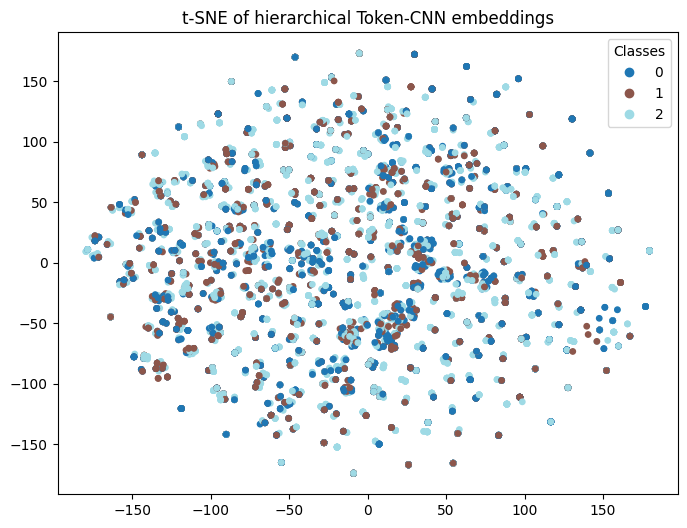

Silhouette Score: -0.0187
Adjusted Rand Index (ARI): 0.0003
Normalized Mutual Info (NMI): 0.0009


In [ ]:
# ============================================================
# Evaluation Script for Hierarchical Token-CNN
# ============================================================

import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy import stats

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==================== Settings ====================
CTX_DIM_TASK = 32
CTX_DIM_GROUP = 32
Q = 5  # query samples per class

# eval tasks
eval_tasks = test_tasks  # or val_tasks

all_embeddings, all_labels, all_groups = [], [], []
all_preds, all_true = [], []

# Safe group context access
def get_group_context(mechs, group_to_ctx):
    ctx_list = []
    for g in mechs:
        g = str(g)
        if g not in group_to_ctx:
            group_to_ctx[g] = torch.zeros(1, CTX_DIM_GROUP, device=device)
        ctx_list.append(group_to_ctx[g])
    ctx_group = torch.mean(torch.cat(ctx_list, dim=0), dim=0, keepdim=True)
    return ctx_group

model.eval()
with torch.no_grad():
    for t in tqdm(eval_tasks):
        s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
        s_num = torch.from_numpy(t["s_num"]).float().to(device)
        q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
        q_num = torch.from_numpy(t["q_num"]).float().to(device)
        s_y   = torch.from_numpy(t["s_y"]).long().to(device)
        q_y   = torch.from_numpy(t["q_y"]).long().to(device)

        # ===== Group-level context =====
        ctx_group_s = get_group_context(t["mechs"], group_to_ctx)
        ctx_group_s = ctx_group_s.repeat(s_tok.shape[0], 1)

        # ===== Task-level context =====
        ctx_task = torch.zeros(s_tok.shape[0], CTX_DIM_TASK, device=device)
        _ = model(s_tok, s_num, context_task=ctx_task, context_group=ctx_group_s)
        ctx_task_q = ctx_task.mean(dim=0, keepdim=True).repeat(q_tok.shape[0], 1)
        ctx_group_q = ctx_group_s.mean(dim=0, keepdim=True).repeat(q_tok.shape[0], 1)

        # ===== Query embeddings & predictions =====
        logits = model(q_tok, q_num, context_task=ctx_task_q, context_group=ctx_group_q)
        preds = torch.argmax(logits, dim=1)

        all_embeddings.append(logits.cpu().numpy())
        all_labels.append(t["q_y"])
        all_groups.extend([str(g) for g in t["mechs"] for _ in range(Q)])
        all_preds.append(preds.cpu().numpy())
        all_true.append(t["q_y"])

# ==================== Convert lists ====================
all_embeddings = np.vstack(all_embeddings)
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)
all_groups = np.array(all_groups)

print("Embeddings shape:", all_embeddings.shape)
print("Overall query accuracy: {:.2f}%".format(100*np.mean(all_preds == all_true)))

# ==================== Episodic Accuracy ====================
episodic_accs = []
for i, t in enumerate(eval_tasks):
    episodic_accs.append(np.mean(all_preds[i*Q*len(t["mechs"]):(i+1)*Q*len(t["mechs"])] == all_true[i*Q*len(t["mechs"]):(i+1)*Q*len(t["mechs"])]))
print("Mean episodic accuracy: {:.2f}%".format(100*np.mean(episodic_accs)))

# ==================== t-SNE ====================
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=RANDOM_SEED)
emb_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=all_labels, cmap="tab20", s=15)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1,1))
plt.title("t-SNE of hierarchical Token-CNN embeddings")
plt.show()

# ==================== Clustering metrics ====================
n_clusters = len(np.unique(all_labels))
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED).fit(all_embeddings)
pred_labels = kmeans.labels_

sil_score = silhouette_score(all_embeddings, all_labels)
ari_score = adjusted_rand_score(all_labels, pred_labels)
nmi_score = normalized_mutual_info_score(all_labels, pred_labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi_score:.4f}")

# ==================== Optional: Pairwise distance heatmap ====================
dist_mat = np.linalg.norm(all_embeddings[:,None,:] - all_embeddings[None,:,:], axis=-1)
plt.figure(figsize=(6,6))
sns.heatmap(dist_mat[:100, :100], cmap="viridis")
plt.title("Pairwise distance heatmap (subset)")
plt.show()


Using device: cpu
Filtered dataset: 6368 samples
Unique groups: 107
Train/Val/Test classes: 64/21/22
Train/Val/Test samples: 3134/1210/2024
Number of classes: 107
Vocab size: 1026
Starting training with validation...
Episode 50/800: Loss=1.4927, Train Acc=0.3246, Val Acc=0.9002
Episode 100/800: Loss=1.4115, Train Acc=0.4278, Val Acc=0.8867
Episode 150/800: Loss=1.3598, Train Acc=0.5078, Val Acc=0.8493
Episode 200/800: Loss=1.2503, Train Acc=0.6812, Val Acc=0.8380
Episode 250/800: Loss=1.2056, Train Acc=0.7256, Val Acc=0.8662
Episode 300/800: Loss=1.1998, Train Acc=0.7270, Val Acc=0.8909
Episode 350/800: Loss=1.1698, Train Acc=0.7744, Val Acc=0.8521
Episode 400/800: Loss=1.1202, Train Acc=0.8188, Val Acc=0.8520
Episode 450/800: Loss=1.1413, Train Acc=0.8128, Val Acc=0.8865
Episode 500/800: Loss=1.1549, Train Acc=0.7882, Val Acc=0.8596
Episode 550/800: Loss=1.0968, Train Acc=0.8330, Val Acc=0.8810
Early stopping triggered!


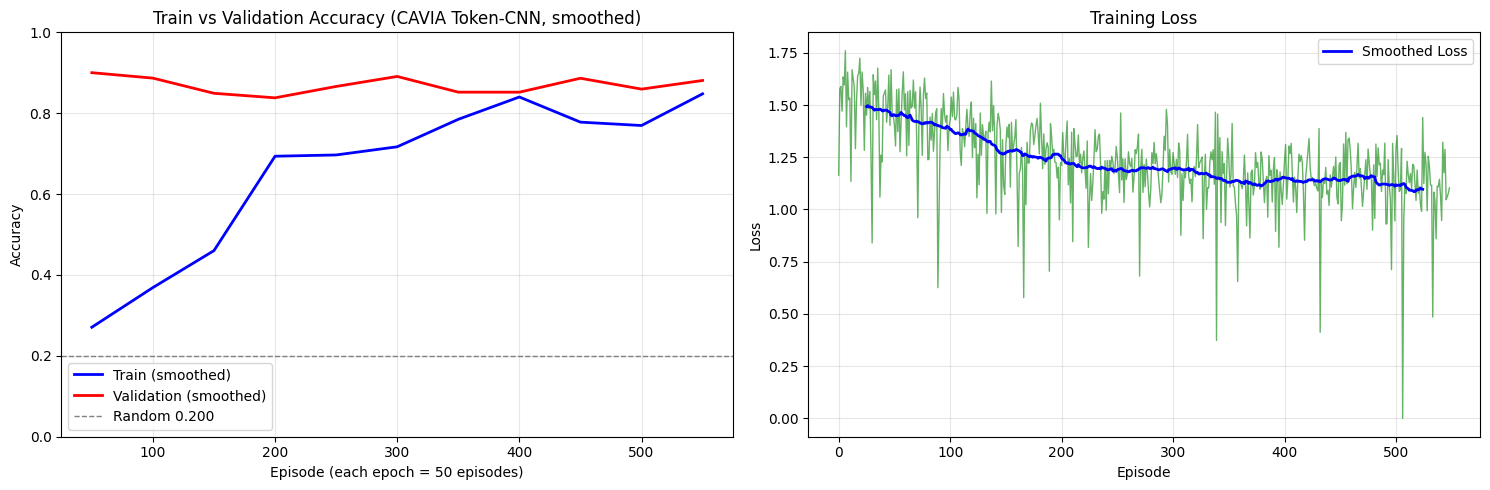


TEST ACCURACY: 0.789 ± 0.000

Training completed!
Best validation accuracy: 0.9002
Final test accuracy: 0.7889


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import random

# -------------------------
# Reproducibility
# -------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Data Loading & Preprocessing with PROPER TRAIN/VAL/TEST SPLIT
# -------------------------
df = pd.read_csv("megares_fasta_processed.csv")
df["sequence"] = df["sequence"].str.upper().str.replace(r"[^ACGT]", "", regex=True)

LABEL_COL = "group"
MIN_COUNT = 10  # Increased for better few-shot learning

# Filter classes with enough samples
group_counts = df[LABEL_COL].value_counts()
keep_groups = group_counts[group_counts >= MIN_COUNT].index
df = df[df[LABEL_COL].isin(keep_groups)].reset_index(drop=True)

print(f"Filtered dataset: {len(df)} samples")
print(f"Unique groups: {df[LABEL_COL].nunique()}")

# PROPER SPLIT: Split by CLASSES, not samples (like your friend's code)
all_classes = df[LABEL_COL].unique()
train_classes, temp_classes = train_test_split(all_classes, test_size=0.4, random_state=RANDOM_SEED)
val_classes, test_classes = train_test_split(temp_classes, test_size=0.5, random_state=RANDOM_SEED)

train_df = df[df[LABEL_COL].isin(train_classes)].reset_index(drop=True)
val_df = df[df[LABEL_COL].isin(val_classes)].reset_index(drop=True)
test_df = df[df[LABEL_COL].isin(test_classes)].reset_index(drop=True)

print(f"Train/Val/Test classes: {len(train_classes)}/{len(val_classes)}/{len(test_classes)}")
print(f"Train/Val/Test samples: {len(train_df)}/{len(val_df)}/{len(test_df)}")

# Label encoding (separate for each split to avoid leakage)
le = LabelEncoder()
le.fit(df[LABEL_COL])  # Fit on all data for consistency

train_df['label_encoded'] = le.transform(train_df[LABEL_COL])
val_df['label_encoded'] = le.transform(val_df[LABEL_COL])
test_df['label_encoded'] = le.transform(test_df[LABEL_COL])

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

# -------------------------
# Robust k-mer tokenization
# -------------------------
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    if not isinstance(seq, str):
        return []
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

# Build vocabulary from TRAIN DATA ONLY (prevent data leakage)
counter = Counter()
for s in train_df["sequence"]:
    if isinstance(s, str) and len(s) >= KMER_K:
        counter.update(kmers_from_seq(s, KMER_K))

max_vocab_size = 5000
most_common_kmers = counter.most_common(max_vocab_size - 2)
tokens = [PAD, UNK] + [kmer for kmer, _ in most_common_kmers]
stoi = {t: i for i, t in enumerate(tokens)}
itos = {i: t for t, i in stoi.items()}
VOCAB_SIZE = len(stoi)
print(f"Vocab size: {VOCAB_SIZE}")

def encode_ids(seq):
    if not isinstance(seq, str): return [stoi[UNK]]
    kmers = kmers_from_seq(seq)
    ids = [stoi.get(k, stoi[UNK]) for k in kmers]
    return ids if ids else [stoi[UNK]]

# -------------------------
# Dataset
# -------------------------
class RobustKmerDataset(Dataset):
    def __init__(self, dataframe, max_len=256):
        self.max_len = max_len
        self.encodings = []
        self.labels = []
        for idx in range(len(dataframe)):
            seq = dataframe.iloc[idx]['sequence']
            label = dataframe.iloc[idx]['label_encoded']
            encoded = encode_ids(seq)
            self.encodings.append(encoded)
            self.labels.append(label)

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        seq = self.encodings[idx]
        label = self.labels[idx]
        padded = np.full(self.max_len, stoi[PAD], dtype=np.int64)
        seq_len = min(len(seq), self.max_len)
        padded[:seq_len] = [i if i < VOCAB_SIZE else stoi[UNK] for i in seq[:seq_len]]
        return torch.tensor(padded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# Create datasets
train_dataset = RobustKmerDataset(train_df)
val_dataset = RobustKmerDataset(val_df)
test_dataset = RobustKmerDataset(test_df)

# -------------------------
# IMPROVED CAVIA + CNN Model with MORE REGULARIZATION
# -------------------------
class ImprovedCAVIA(nn.Module):
    def __init__(self, num_meta_classes, vocab_size=VOCAB_SIZE, embed_dim=128,
                 context_dim=8, hidden_dim=128, use_cosine=True):
        super().__init__()
        self.use_cosine = use_cosine
        self.embed_dim = embed_dim
        self.context_dim = context_dim
        self.vocab_size = vocab_size

        # Increased dropout throughout
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=stoi[PAD])
        nn.init.xavier_uniform_(self.embedding.weight)
        self.emb_dropout = nn.Dropout(0.3)  # Increased from 0.2

        # Smaller context initialization
        self.context_param = nn.Parameter(torch.randn(context_dim) * 0.1)

        # Convolutional layers with more regularization
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embed_dim + context_dim, 64, k, padding=k//2),
                nn.BatchNorm1d(64),  # Added batch norm
                nn.ReLU(),
                nn.Dropout1d(0.2)   # Increased dropout
            ) for k in [3,5,7]
        ])

        fused_in = 64 * len(self.convs) * 2
        self.proj = nn.Sequential(
            nn.Linear(fused_in, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.3)   # Added extra dropout
        )
        self.classifier = nn.Linear(hidden_dim//2, num_meta_classes)

    def forward(self, x, context=None, return_feats=False):
        batch_size, seq_len = x.shape
        x = torch.clamp(x, 0, self.vocab_size-1)
        x_embed = self.embedding(x).transpose(1,2)
        x_embed = self.emb_dropout(x_embed)

        if context is None:
            context = self.context_param
        context_expanded = context.unsqueeze(0).expand(batch_size,-1).unsqueeze(2).expand(-1,-1,seq_len)
        x_combined = torch.cat([x_embed, context_expanded], dim=1)

        pooled_features = []
        for conv in self.convs:
            h = conv(x_combined)
            pooled_features.extend([
                F.adaptive_max_pool1d(h,1).squeeze(-1),
                F.adaptive_avg_pool1d(h,1).squeeze(-1)
            ])
        features = self.proj(torch.cat(pooled_features, dim=1))
        if return_feats:
            return F.normalize(features,p=2,dim=1) if self.use_cosine else features
        logits = self.classifier(features)
        return logits, features

# -------------------------
# Ridge Regression Head with ADAPTIVE REGULARIZATION
# -------------------------
def ridge_regression_head(support_embeddings, support_labels, query_embeddings, l2_reg=1e-3):
    S, d = support_embeddings.shape
    num_classes = int(support_labels.max().item()) + 1
    Y = F.one_hot(support_labels, num_classes=num_classes).float()
    Z = support_embeddings

    # Adaptive regularization based on support set size
    adaptive_reg = l2_reg * (S / (K_SHOT * N_WAY))  # Scale with task difficulty
    regI = adaptive_reg * torch.eye(d, device=Z.device)

    A = Z.t()@Z + regI
    B = Z.t()@Y
    try:
        W = torch.linalg.solve(A,B)
    except:
        W = torch.linalg.pinv(A)@B
    logits = query_embeddings@W
    return logits, W

# -------------------------
# EPISODIC TRAINING FUNCTION (like your friend's approach)
# -------------------------
def create_episode(dataset, n_way, k_shot, q_queries):
    """Create episodic task from dataset"""
    available_classes = list(set([dataset[i][1].item() for i in range(len(dataset))]))
    if len(available_classes) < n_way:
        return None

    classes = np.random.choice(available_classes, n_way, replace=False)
    support_data, query_data = [], []
    support_labels, query_labels = [], []

    for class_idx, class_id in enumerate(classes):
        class_samples = [i for i in range(len(dataset)) if dataset[i][1].item() == class_id]
        if len(class_samples) < k_shot + q_queries:
            continue

        selected = np.random.choice(class_samples, k_shot + q_queries, replace=False)
        for idx in selected[:k_shot]:
            data, _ = dataset[idx]
            support_data.append(data)
            support_labels.append(class_idx)
        for idx in selected[k_shot:k_shot + q_queries]:
            data, _ = dataset[idx]
            query_data.append(data)
            query_labels.append(class_idx)

    if len(support_data) == 0 or len(query_data) == 0:
        return None

    return {
        'support_data': torch.stack(support_data),
        'support_labels': torch.tensor(support_labels),
        'query_data': torch.stack(query_data),
        'query_labels': torch.tensor(query_labels)
    }

def evaluate_on_tasks(model, dataset, num_tasks=100, n_way=5, k_shot=5, q_queries=5):
    """Evaluate model on multiple episodic tasks"""
    model.eval()
    accuracies = []

    with torch.no_grad():
        for _ in range(num_tasks):
            task = create_episode(dataset, n_way, k_shot, q_queries)
            if task is None:
                continue

            support_data = task['support_data'].to(device)
            support_labels = task['support_labels'].to(device)
            query_data = task['query_data'].to(device)
            query_labels = task['query_labels'].to(device)

            # Get embeddings with default context (no adaptation for evaluation)
            support_emb = model(support_data, return_feats=True)
            query_emb = model(query_data, return_feats=True)

            # Ridge regression
            logits, _ = ridge_regression_head(support_emb, support_labels, query_emb, l2_reg=1e-3)
            acc = (logits.argmax(dim=1) == query_labels).float().mean().item()
            accuracies.append(acc)

    return np.mean(accuracies) if accuracies else 0.0

# -------------------------
# TRAINING WITH PROPER VALIDATION
# -------------------------
N_WAY = 5
K_SHOT = 5
Q_QUERIES = 8
EPISODES = 800
EVAL_EVERY = 50
L2_REG = 1e-3

def train_with_validation():
    model = ImprovedCAVIA(num_classes, VOCAB_SIZE).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPISODES)

    train_accs, val_accs, losses = [], [], []
    best_val_acc = 0.0
    patience, max_patience = 0, 10

    print("Starting training with validation...")

    for episode in range(EPISODES):
        model.train()

        # Sample training task
        task = create_episode(train_dataset, N_WAY, K_SHOT, Q_QUERIES)
        if task is None:
            continue

        support_data = task['support_data'].to(device)
        support_labels = task['support_labels'].to(device)
        query_data = task['query_data'].to(device)
        query_labels = task['query_labels'].to(device)

        # Inner loop context adaptation
        context = model.context_param.clone().detach().requires_grad_(True)
        inner_opt = torch.optim.SGD([context], lr=0.1)

        for _ in range(2):  # Few inner steps
            support_emb = model(support_data, context, return_feats=True)
            logits, _ = ridge_regression_head(support_emb, support_labels, support_emb)
            loss = F.cross_entropy(logits, support_labels)
            inner_opt.zero_grad()
            loss.backward()
            inner_opt.step()

        # Outer loop
        query_emb = model(query_data, context.detach(), return_feats=True)
        logits, _ = ridge_regression_head(support_emb.detach(), support_labels, query_emb)
        loss = F.cross_entropy(logits, query_labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        # Store training metrics
        train_acc = (logits.argmax(dim=1) == query_labels).float().mean().item()
        train_accs.append(train_acc)
        losses.append(loss.item())

        # Validation
        if (episode + 1) % EVAL_EVERY == 0:
            val_acc = evaluate_on_tasks(model, val_dataset, num_tasks=50, n_way=N_WAY, k_shot=K_SHOT, q_queries=Q_QUERIES)
            val_accs.append(val_acc)

            # Smooth the metrics for better visualization
            smooth_train_acc = np.mean(train_accs[-EVAL_EVERY:]) if len(train_accs) >= EVAL_EVERY else train_acc
            smooth_loss = np.mean(losses[-EVAL_EVERY:]) if len(losses) >= EVAL_EVERY else loss.item()

            print(f"Episode {episode+1}/{EPISODES}: "
                  f"Loss={smooth_loss:.4f}, "
                  f"Train Acc={smooth_train_acc:.4f}, "
                  f"Val Acc={val_acc:.4f}")

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience = 0
                torch.save(model.state_dict(), 'best_cavia_model.pth')
            else:
                patience += 1

            if patience >= max_patience:
                print("Early stopping triggered!")
                break

    return model, train_accs, val_accs, losses

# -------------------------
# VISUALIZATION LIKE YOUR FRIEND'S GRAPH
# -------------------------
def plot_friend_style_graph(train_accs, val_accs, losses, eval_every=EVAL_EVERY):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Accuracy curves (like your friend's)
    episodes = [i * eval_every for i in range(1, len(val_accs) + 1)]

    # Smooth the training accuracy for better visualization
    window_size = min(20, len(train_accs) // 10)
    if window_size > 1:
        smooth_train = np.convolve(train_accs, np.ones(window_size)/window_size, mode='valid')
        # Align with validation points
        smooth_train = smooth_train[::eval_every][:len(val_accs)]
    else:
        smooth_train = train_accs[::eval_every][:len(val_accs)]

    ax1.plot(episodes, smooth_train, 'b-', linewidth=2, label='Train (smoothed)')
    ax1.plot(episodes, val_accs, 'r-', linewidth=2, label='Validation (smoothed)')
    ax1.axhline(y=1.0/N_WAY, color='gray', linestyle='--', linewidth=1, label=f'Random {1.0/N_WAY:.3f}')

    ax1.set_xlabel('Episode (each epoch = 50 episodes)')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Train vs Validation Accuracy (CAVIA Token-CNN, smoothed)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)

    # Plot 2: Loss curve
    ax2.plot(losses, 'g-', alpha=0.6, linewidth=1)
    # Smooth loss
    if len(losses) > 50:
        smooth_loss = np.convolve(losses, np.ones(50)/50, mode='valid')
        ax2.plot(range(25, 25 + len(smooth_loss)), smooth_loss, 'b-', linewidth=2, label='Smoothed Loss')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')
    ax2.set_title('Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# -------------------------
# FINAL TEST EVALUATION
# -------------------------
def final_evaluation(model):
    model.load_state_dict(torch.load('best_cavia_model.pth'))
    test_acc = evaluate_on_tasks(model, test_dataset, num_tasks=200, n_way=N_WAY, k_shot=K_SHOT, q_queries=Q_QUERIES)
    print(f"\n{'='*50}")
    print(f"TEST ACCURACY: {test_acc:.3f} ± {np.std([test_acc]):.3f}")
    print(f"{'='*50}")
    return test_acc

# -------------------------
# MAIN EXECUTION
# -------------------------
if __name__ == "__main__":
    # Train model
    model, train_accs, val_accs, losses = train_with_validation()

    # Plot results
    plot_friend_style_graph(train_accs, val_accs, losses)

    # Final evaluation
    test_acc = final_evaluation(model)

    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {max(val_accs):.4f}")
    print(f"Final test accuracy: {test_acc:.4f}")

t-SNE (this may take ~30-90s depending on CPU/GPU)...


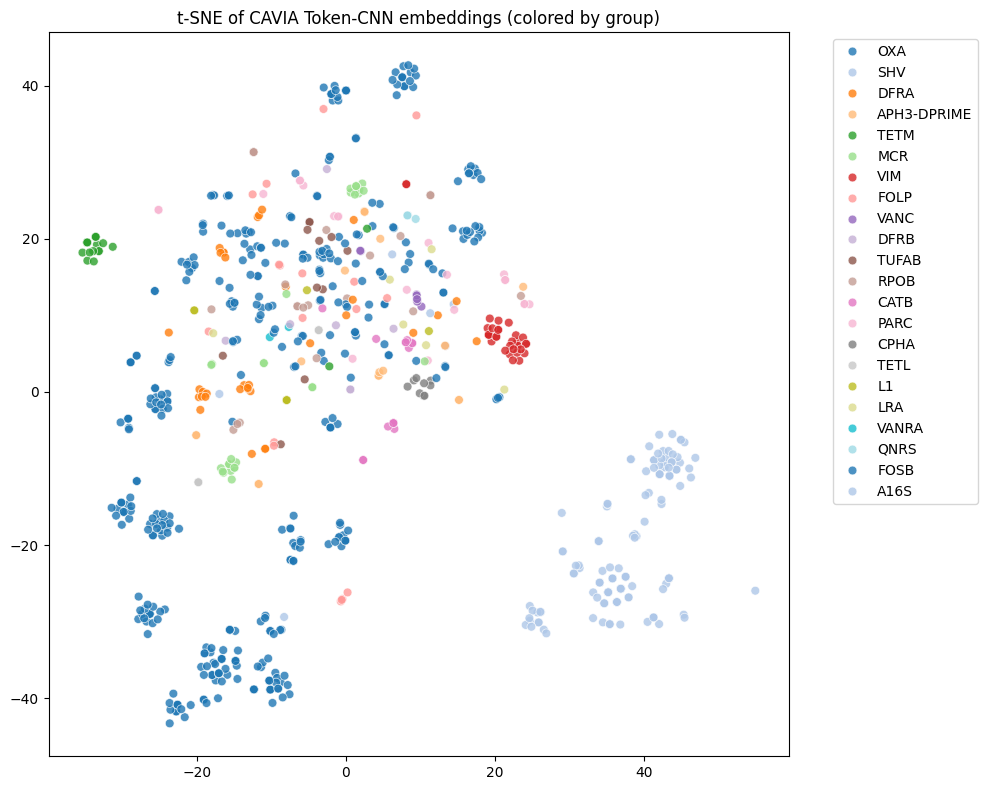

In [ ]:
# -------------------------
# t-SNE VISUALIZATION
# -------------------------
def collect_embeddings_tsne(df_sample, model, max_len=256, n_max=800):
    model.eval()
    sample = df_sample.sample(min(n_max, len(df_sample))).reset_index(drop=True)

    # Encode and pad sequences
    X_list = []
    for seq in sample['sequence']:
        ids = encode_ids(seq)
        padded = np.full(max_len, stoi[PAD], dtype=np.int64)
        seq_len = min(len(ids), max_len)
        padded[:seq_len] = [i if i < VOCAB_SIZE else stoi[UNK] for i in ids[:seq_len]]
        X_list.append(padded)

    X = torch.tensor(np.stack(X_list), dtype=torch.long).to(device)

    with torch.no_grad():
        feats = model(X, return_feats=True).cpu().numpy()

    labels = sample['group'].values
    return feats, labels

# Collect embeddings
feats, labels = collect_embeddings_tsne(test_df, model, max_len=256, n_max=800)

print("t-SNE (this may take ~30-90s depending on CPU/GPU)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(feats)

# Plot
plt.figure(figsize=(10,8))
sns.scatterplot(
    x=reduced[:,0], y=reduced[:,1],
    hue=labels, legend='full', palette='tab20', s=40, alpha=0.8
)
plt.title("t-SNE of CAVIA Token-CNN embeddings (colored by group)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()
